<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-the-tiff-files-and-calculate-band-5-reflectance" data-toc-modified-id="Get-the-tiff-files-and-calculate-band-5-reflectance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the tiff files and calculate band 5 reflectance</a></span></li><li><span><a href="#Save-the-crs-and-the-full_affine" data-toc-modified-id="Save-the-crs-and-the-full_affine-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save the crs and the full_affine</a></span></li><li><span><a href="#Locate-UBC-on-the-map" data-toc-modified-id="Locate-UBC-on-the-map-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Locate UBC on the map</a></span></li><li><span><a href="#Locate-UBC-on-the-image" data-toc-modified-id="Locate-UBC-on-the-image-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Locate UBC on the image</a></span></li><li><span><a href="#make-our-subscene-400-pixels-wide-and-600-pixels-tall,-using-UBC-as-a-reference-point" data-toc-modified-id="make-our-subscene-400-pixels-wide-and-600-pixels-tall,-using-UBC-as-a-reference-point-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>make our subscene 400 pixels wide and 600 pixels tall, using UBC as a reference point</a></span></li><li><span><a href="#Plot-the-raw-band-5-image,-clipped-to-reflectivities-below-0.6" data-toc-modified-id="Plot-the-raw-band-5-image,-clipped-to-reflectivities-below-0.6-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot the raw band 5 image, clipped to reflectivities below 0.6</a></span></li><li><span><a href="#put-this-on-a-map" data-toc-modified-id="put-this-on-a-map-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>put this on a map</a></span></li><li><span><a href="#Use--rasterio--to-write-a-new-tiff-file" data-toc-modified-id="Use--rasterio--to-write-a-new-tiff-file-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Use  rasterio  to write a new tiff file</a></span><ul class="toc-item"><li><span><a href="#Set-the-affine-transform-for-the-scene" data-toc-modified-id="Set-the-affine-transform-for-the-scene-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Set the affine transform for the scene</a></span></li><li><span><a href="#Now-write-this-out-to-small_file.tiff" data-toc-modified-id="Now-write-this-out-to-small_file.tiff-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Now write this out to small_file.tiff</a></span></li></ul></li></ul></div>

# Introduction

We need to be able to select a small region of a landsat image to work with.  This notebook 

1. zooms in on a 400 pixel wide x 600 pixel high subscene centered on  Vancouver,  using pyproj and the affine transform to map from lat,lon to x,y in UTM zone 10N to row, column in the landsat image

2. Puts on crude coastlines in the UTM-10N crs

3. Calculates the new affine transform for the subcene, and writes the image out to a 1 Mbyte tiff file


In [11]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import cartopy.crs as ccrs
from rasterio import windows
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import toa_reflectance_8
import pprint
from a301.utils.data_read import download
from pathlib import Path
from affine import Affine
from a301.landsat.landsat_metadata import landsat_metadata


filenames=["LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF",
    "LC08_L1TP_190031_20170528_20170615_01_T1_B5.TIF",
    "LC08_L1TP_190031_20170528_20170615_01_T1_MTL.txt"]

dest_folder=a301.data_dir / Path("landsat8/italy")
for the_file in filenames:
    landsat_tif = Path('landsat_scenes/l8_italy') / Path(the_file)
    download(str(landsat_tif),dest_folder=dest_folder)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_italy/LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF

LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF already exists
and is 124751538 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_italy/LC08_L1TP_190031_20170528_20170615_01_T1_B5.TIF
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\LC08_L1TP_190031_20170528_20170615_01_T1_B5.TIF

LC08_L1TP_190031_20170528_20170615_01_T1_B5.TIF already exists
and is 124751538 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat_scenes/l8_italy/LC08_L1TP_190031_20170528_20170615_01_T1_MTL.txt
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\LC08_L1TP_190031_20170528_20170615_01_T1_MTL.txt

LC08_L

# Get the tiff files and calculate band 5 reflectance

In [12]:
band4=list(dest_folder.glob("*_B4.TIF"))[0]
band5=list(dest_folder.glob("*_B5.TIF"))[0]
mtl_file=list(dest_folder.glob("*MTL.txt"))[0]

# Save the crs and the full_affine

We need to keep both full_affine (the affine transform for the full scene, and the coordinate reference system for pyproj (called crs below)

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Text(0.5,1,'band 5 reflectance whole scene')

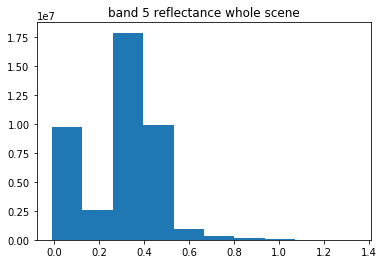

In [13]:
import rasterio.features
import rasterio.warp
with rasterio.open(str(band5)) as b5_raster:
    full_affine=b5_raster.transform
    crs=b5_raster.crs
    full_profile=b5_raster.profile
    refl=toa_reflectance_8([5],mtl_file)
    b5_refl=refl[5]
    
    print(b5_refl)
            
plt.hist(b5_refl[~np.isnan(b5_refl)].flat)
plt.title('band 5 reflectance whole scene')

In [14]:
print(f"profile: \n{pprint.pformat(full_profile)}")

profile: 
{'count': 1,
 'crs': CRS({'init': 'epsg:32633'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7951,
 'interleave': 'band',
 'nodata': None,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 271185.0,
       0.0, -30.0, 4742715.0),
 'width': 7841}


# Locate UBC on the map

We need to project the center of campus from lon/lat to UTM 10N x,y using pyproj_transform and our crs (which in this case is UTM).  We can transform from lon,lat (p_lonlat) to x,y (p_utm) to anchor us to a known point in the map coordinates.

In [15]:
p_utm = Proj(crs)
p_lonlat=Proj(proj='latlong',datum='WGS84')
italy_lon = 13.66477
italy_lat = 41.75983
italy_x, italy_y =proj_transform(p_lonlat,p_utm,italy_lon, italy_lat) 
italy_x, italy_y

# print(italy_x,italy_y)

(389003.43738358404, 4623972.444930574)

# Locate ITALY on the image

Now we need to use the affine transform to go between x,y and 
col, row on the image.  The next cell creates two slice objects that extend  on either side of the center point.  The tilde (~) in front of the transform indicates that we're going from x,y to col,row, instead of col,row to x,y.  (See [this blog entry](http://www.perrygeo.com/python-affine-transforms.html) for reference.)  Remember that row 0 is the top row, with rows decreasing downward to the south.  To demonstrate, the cell below uses the tranform to calculate the x,y coordinates of the (0,0) corner.

In [16]:
full_ul_xy=np.array(full_affine*(0,0))
print(f"orig ul corner x,y (km)={full_ul_xy*1.e-3}")

orig ul corner x,y (km)=[ 271.185 4742.715]


# make our subscene 400 pixels wide and 600 pixels tall, using ITALY as a reference point

We need to find the right rows and columns on the image to save for the subscene.  Do this by working outward from ITALY by a certain number of pixels in each direction, using the inverse of the full_affine transform to go from x,y to col,row

In [17]:
italy_col, italy_row = ~full_affine*(italy_x,italy_y)
italy_col, italy_row = int(italy_col), int(italy_row)
l_col_offset= -1300
r_col_offset= +2000
b_row_offset= +2600
t_row_offset= -100
col_slice=slice(italy_col+l_col_offset,italy_col+r_col_offset)
row_slice=slice(italy_row + t_row_offset, italy_row + b_row_offset)
section=b5_refl[row_slice,col_slice]
print(row_slice,col_slice)
print(section)
italy_ul_xy = full_affine*(col_slice.start,row_slice.start)
italy_lr_xy = full_affine*(col_slice.stop,row_slice.stop)
italy_ul_xy,italy_lr_xy

slice(3858, 6558, None) slice(2627, 5927, None)
[[0.47491896 0.49450645 0.39232725 ... 0.7594261  0.701241   0.5915333 ]
 [0.48055977 0.51991236 0.44562656 ... 0.726647   0.6481638  0.44373885]
 [0.48742205 0.52444285 0.4690116  ... 0.7321102  0.63939166 0.49239665]
 ...
 [0.01370235 0.01352469 0.01399106 ... 0.64192337 0.6615775  0.67301464]
 [0.01334703 0.0135469  0.01399106 ... 0.5838938  0.60010564 0.61900467]
 [0.01421314 0.01427976 0.01476834 ... 0.5272189  0.5344143  0.5748995 ]]


((349995.0, 4626975.0), (448995.0, 4545975.0))

# Plot the raw band 5 image, clipped to reflectivities below 0.6

Note that the origin is "upper" because the (0,0) pixel is the upper
left corner.  This is a simple check that we got the right section.

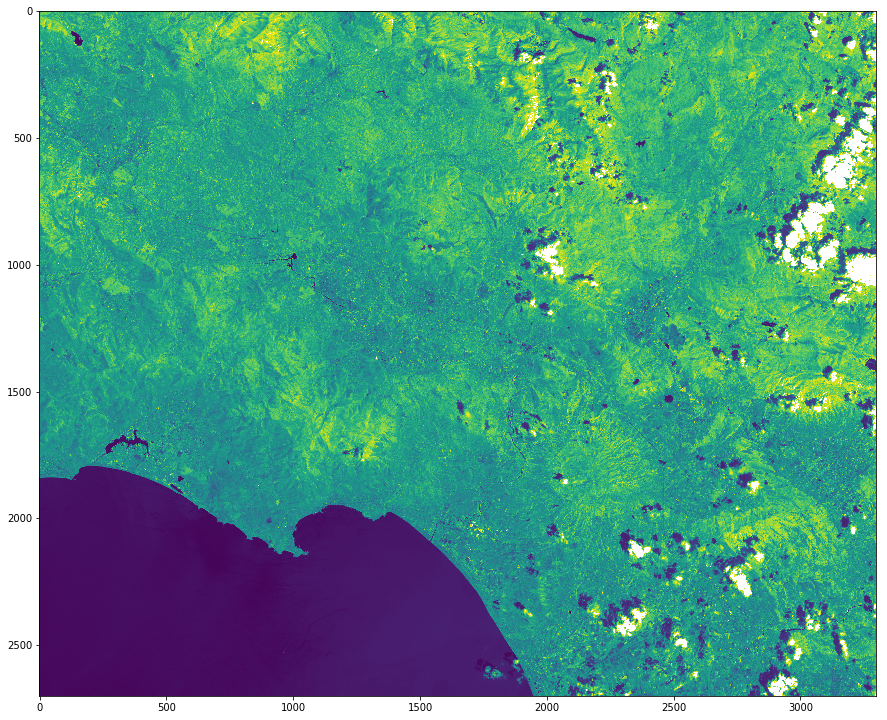

In [18]:
vmin=0.0
vmax=0.6
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
palette='viridis'
pal = plt.get_cmap(palette)
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('w')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
fig, ax = plt.subplots(1,1,figsize=(15,25))
ax.imshow(section,cmap=pal,norm=the_norm,origin="upper");

# put this on a map

Note that the origin is switched to "lower" in the x,y coordinate system below,
since y increases upwards.  The coastline is very crude, but at least indicates we've got the coords roughly correct.  See the "high_res_map" notebook for a better coastline.

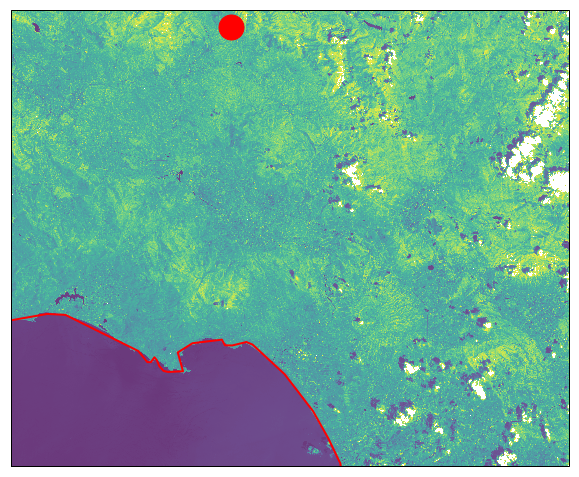

In [19]:
espg=32633
cartopy_crs=cartopy.crs.epsg(espg)
fig, ax = plt.subplots(1, 1,figsize=[10,15],
                       subplot_kw={'projection': cartopy_crs})
image_extent=[italy_ul_xy[0],italy_lr_xy[0],italy_ul_xy[1],italy_lr_xy[1]]
ax.imshow(section,cmap=pal,norm=the_norm,origin="lower",
         extent=image_extent,transform=cartopy_crs,alpha=0.8);
ax.coastlines(resolution='10m',color='red',lw=2);
ax.plot(italy_x, italy_y,'ro',markersize=25)
ax.set_extent(image_extent,crs=cartopy_crs)

# Use  rasterio  to write a new tiff file

## Set the affine transform for the scene

We can write this clipped image back out to a much smaller tiff file if we can come up with the new affine transform for the smaller scene.  Referring again [to the writeup](http://www.perrygeo.com/python-affine-transforms.html) we need:

    a = width of a pixel
    b = row rotation (typically zero)
    c = x-coordinate of the upper-left corner of the upper-left pixel
    d = column rotation (typically zero)
    e = height of a pixel (typically negative)
    f = y-coordinate of the of the upper-left corner of the upper-left pixel

which will gives:

new_affine=Affine(a,b,c,d,e,f)

In addition, need to add a third dimension to the section array, because
rasterio expects [band,x,y] for its writer.  Do this with np.newaxis in the next cell

In [20]:
image_height, image_width = section.shape
print(image_height, image_width)
ul_x, ul_y = italy_ul_xy[0], italy_ul_xy[1]
new_affine=(30.,0.,ul_x,0.,-30.,ul_y)
out_section=section[np.newaxis,...]

2700 3300


##  Now write this out to small_file.tiff

See the hires_map notebook for how to read this in and plot it

In [21]:
tif_filename=a301.data_dir / Path('italy_small_file.tiff')    
num_chans=1
with rasterio.open(str(tif_filename),'w',driver='GTiff',
                   height=image_height,width=image_width,
                   count=num_chans,dtype=np.float32,
                   crs=crs,transform=new_affine, nodata=0.0) as dst:
        dst.write(out_section)
        section_profile=dst.profile
        
print(f"section profile: {pprint.pformat(section_profile)}")

section profile: {'count': 1,
 'crs': CRS({'init': 'epsg:32633'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2700,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 349995.0,
       0.0, -30.0, 4626975.0),
 'width': 3300}
